登录wandb
- 可以通过login登录
- 通过密钥登录  

密钥查询地址：https://wandb.ai/authorize

In [2]:
import wandb
wandb.login()

# import os
# os.environ["WANDB_API_KEY"] = "xxx"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 315680524 (550w). Use `wandb login --relogin` to force relogin


True

## 1、实验跟踪
wandb提供的能力主要包括：
1. 模型配置超参数的记录
2. 模型训练过程中loss，metric等各种指标的记录和可视化
3. 图像的可视化（wandb.Image）
4. 其他各种Media（wandb.Vedio，wandb.Audio，wandb.Html，3D点云等）

In [3]:
import os,PIL 
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch 
from torch import nn 
import torchvision 
from torchvision import transforms
import datetime
import wandb 
from argparse import Namespace

In [4]:
# gpu选择
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')


In [5]:
# 配置（设置后续所有的配置）
config = Namespace(
    project_name = 'wandb_demo',
    
    batch_size = 512,
    
    hidden_layer_width = 64,
    dropout_p = 0.1,
    
    lr = 1e-4,
    optim_type = 'Adam',
    
    epochs = 15,
    ckpt_path = 'checkpoint.pt'
)

In [6]:
# 数据集
def create_dataloaders(config):
    transform = transforms.Compose([transforms.ToTensor()])
    ds_train = torchvision.datasets.MNIST(root="./mnist/",train=True,download=True,transform=transform)
    ds_val = torchvision.datasets.MNIST(root="./mnist/",train=False,download=True,transform=transform)

    ds_train_sub = torch.utils.data.Subset(ds_train, indices=range(0, len(ds_train), 5))
    dl_train =  torch.utils.data.DataLoader(ds_train_sub, batch_size=config.batch_size, shuffle=True,
                                            num_workers=2,drop_last=True)
    dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size, shuffle=False, 
                                          num_workers=2,drop_last=True)
    return dl_train,dl_val

In [7]:
# 模型结构
def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=config.hidden_layer_width,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)) 
    net.add_module("conv2",nn.Conv2d(in_channels=config.hidden_layer_width,
                                     out_channels=config.hidden_layer_width,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(config.hidden_layer_width,config.hidden_layer_width))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(config.hidden_layer_width,10))
    net.to(device)
    return net 

In [8]:
def train_epoch(model,dl_train,optimizer):
    model.train()
    for step, batch in enumerate(dl_train):
        features,labels = batch
        features,labels = features.to(device),labels.to(device)

        preds = model(features)
        loss = nn.CrossEntropyLoss()(preds,labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    return model

In [9]:
def eval_epoch(model,dl_val):
    model.eval()
    accurate = 0
    num_elems = 0
    for batch in dl_val:
        features,labels = batch
        features,labels = features.to(device),labels.to(device)
        with torch.no_grad():
            preds = model(features)
        predictions = preds.argmax(dim=-1)
        accurate_preds =  (predictions==labels)
        num_elems += accurate_preds.shape[0]
        accurate += accurate_preds.long().sum()

    val_acc = accurate.item() / num_elems
    return val_acc

In [10]:
def train(config = config):
    dl_train, dl_val = create_dataloaders(config)
    model = create_net(config); 
    optimizer = torch.optim.__dict__[config.optim_type](params=model.parameters(), lr=config.lr)
    #======================================================================
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    wandb.init(project=config.project_name, config = config.__dict__, name = nowtime, save_code=True)
    model.run_id = wandb.run.id
    #======================================================================
    model.best_metric = -1.0
    for epoch in range(1,config.epochs+1):
        model = train_epoch(model,dl_train,optimizer)
        val_acc = eval_epoch(model,dl_val)
        if val_acc>model.best_metric:
            model.best_metric = val_acc
            torch.save(model.state_dict(),config.ckpt_path)   
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"epoch【{epoch}】@{nowtime} --> val_acc= {100 * val_acc:.2f}%")
        #======================================================================
        wandb.log({'epoch':epoch, 'val_acc': val_acc, 'best_val_acc':model.best_metric})
        #======================================================================        
    #======================================================================
    wandb.finish()
    #======================================================================
    return model   

In [11]:
model = train(config) ##3,2,1 点火🔥🔥

epoch【1】@2023-10-11 23:50:26 --> val_acc= 23.97%
epoch【2】@2023-10-11 23:50:35 --> val_acc= 30.94%
epoch【3】@2023-10-11 23:50:43 --> val_acc= 46.06%
epoch【4】@2023-10-11 23:50:52 --> val_acc= 61.92%
epoch【5】@2023-10-11 23:51:00 --> val_acc= 67.61%
epoch【6】@2023-10-11 23:51:09 --> val_acc= 78.45%
epoch【7】@2023-10-11 23:51:17 --> val_acc= 81.70%
epoch【8】@2023-10-11 23:51:25 --> val_acc= 84.10%
epoch【9】@2023-10-11 23:51:34 --> val_acc= 86.31%
epoch【10】@2023-10-11 23:51:42 --> val_acc= 87.91%
epoch【11】@2023-10-11 23:51:50 --> val_acc= 89.10%
epoch【12】@2023-10-11 23:51:59 --> val_acc= 90.04%
epoch【13】@2023-10-11 23:52:07 --> val_acc= 90.56%
epoch【14】@2023-10-11 23:52:16 --> val_acc= 91.14%
epoch【15】@2023-10-11 23:52:24 --> val_acc= 91.82%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_val_acc,▁▂▃▅▆▇▇▇▇██████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_acc,▁▂▃▅▆▇▇▇▇██████
best_val_acc,0.91817
epoch,15
val_acc,0.91817


- workspace
    - 可以添加section，可以重命名，并添加需要的panel
- runs
    - 可以看到每次实验的相关参数等
    - columns可以选择需要展示的列

## 版本管理
- wandb将实验关联的数据集，代码和模型保存到wandb服务器
- 通过wandb.log_artifact()方法来保存任务的关联的重要成果

In [12]:
# resume the run 
# 使用run_id 恢复 run任务，以便继续记录
import wandb 

run = wandb.init(project='wandb_demo', id= model.run_id, resume='must')

In [13]:
# save dataset 
arti_dataset = wandb.Artifact('mnist', type='dataset')
arti_dataset.add_dir('mnist/')
wandb.log_artifact(arti_dataset)

wandb: Adding directory to artifact (./mnist)... Done. 0.2s


<Artifact mnist>

In [14]:
# save code 

arti_code = wandb.Artifact('ipynb', type='code')
arti_code.add_file('./30分钟吃掉wandb可视化模型分析.ipynb')
wandb.log_artifact(arti_code)

<Artifact ipynb>

In [15]:
# save model

arti_model = wandb.Artifact('cnn', type='model')
arti_model.add_file(config.ckpt_path)
wandb.log_artifact(arti_model)


<Artifact cnn>

In [16]:
wandb.finish() #finish时会提交保存

best_val_acc,0.91817
epoch,15
val_acc,0.91817


## Case分析
- 利用wandb.Table可以在wandb的dashboard进行交互式可视化的case分析

In [23]:
#resume the run 
import wandb 
run = wandb.init(project=config.project_name, id= model.run_id, resume='must')

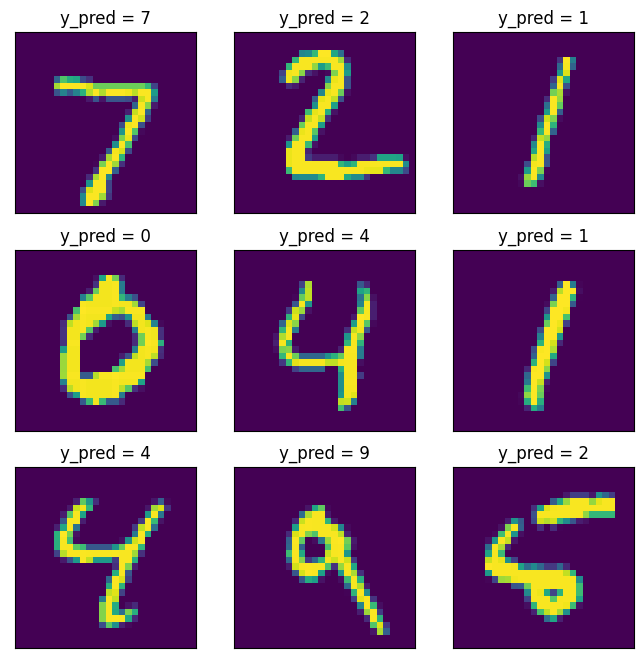

In [24]:
import matplotlib.pyplot as plt 

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="./mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="./mnist/",train=False,download=True,transform=transform)
    
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_val[i]
    tensor = img.to(device)
    y_pred = torch.argmax(model(tensor[None,...])) 
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()    

In [25]:
def data2fig(data):
    import matplotlib.pyplot as plt 
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([]) 
    return fig

def fig2img(fig):
    import io,PIL
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

In [26]:
from tqdm import tqdm 
good_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])
bad_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])

  2%|▏         | 18/1000 [00:00<00:42, 23.30it/s]/var/folders/5y/pzgqqgv92qd3p3t4m01dhbp00000gn/T/ipykernel_29346/3920330832.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
100%|██████████| 1000/1000 [00:05<00:00, 195.55it/s]


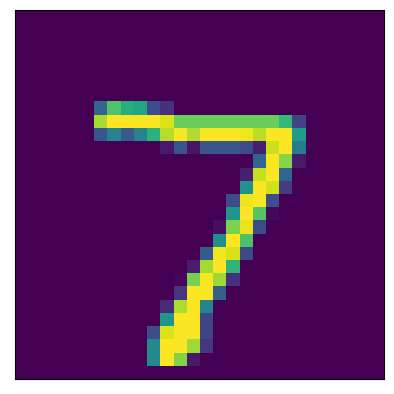

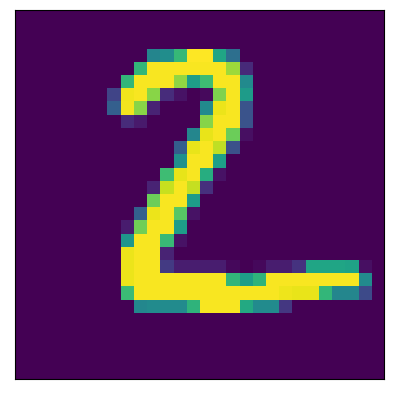

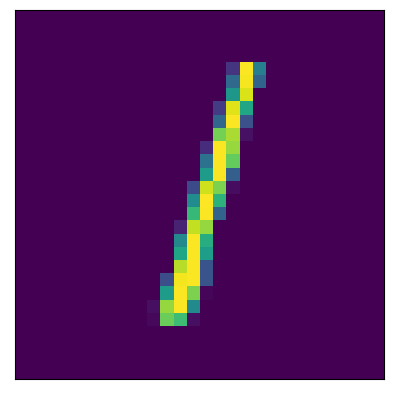

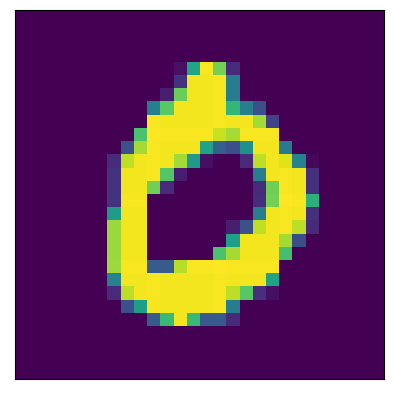

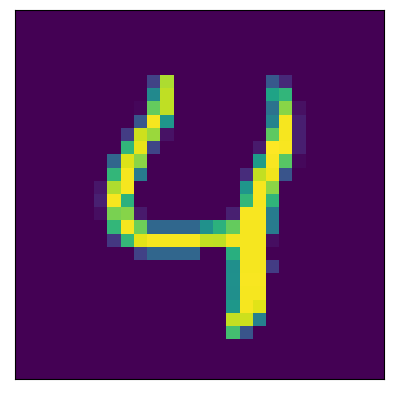

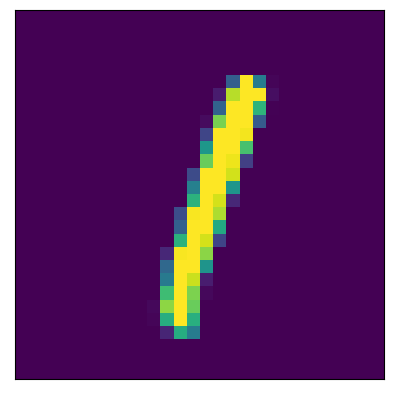

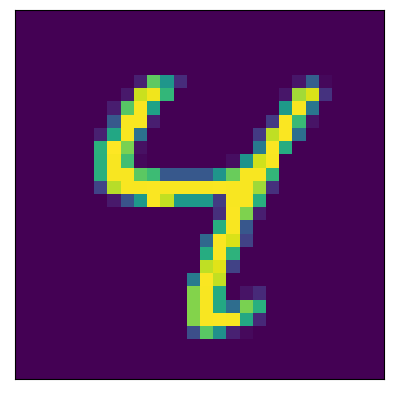

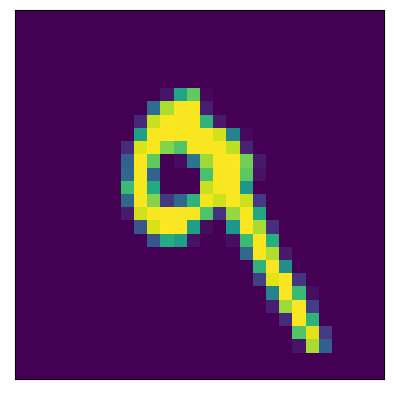

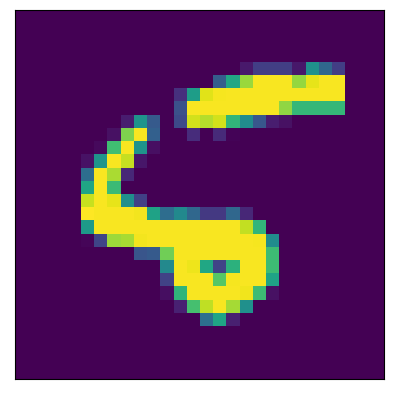

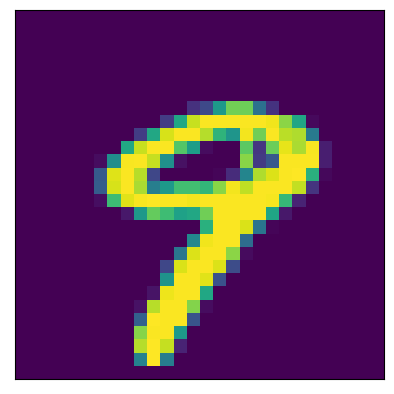

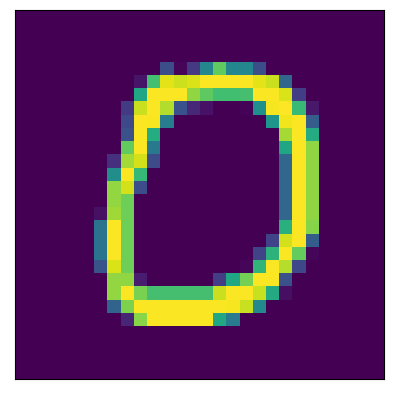

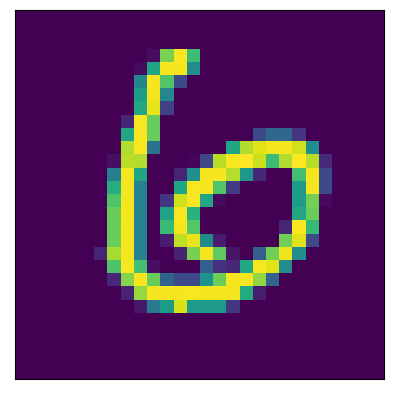

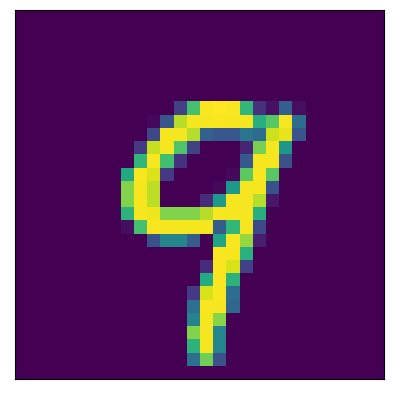

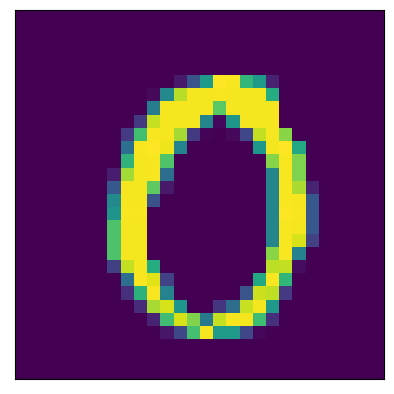

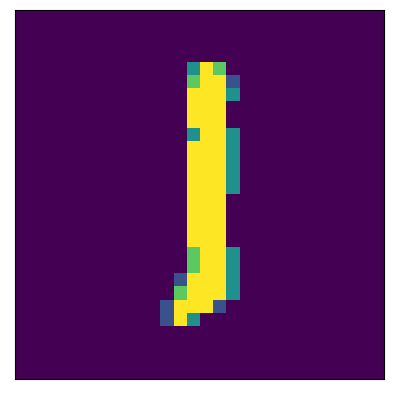

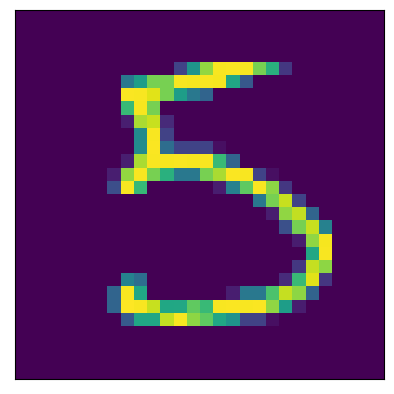

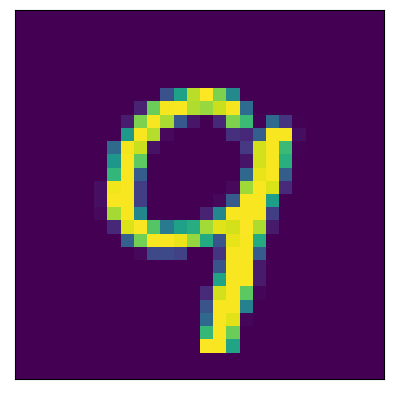

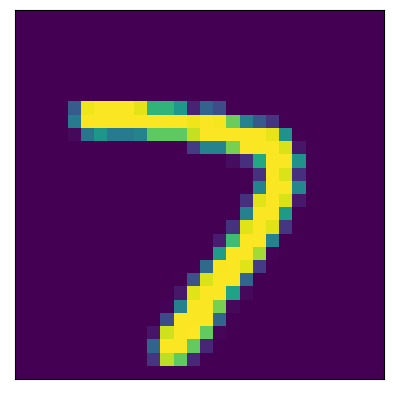

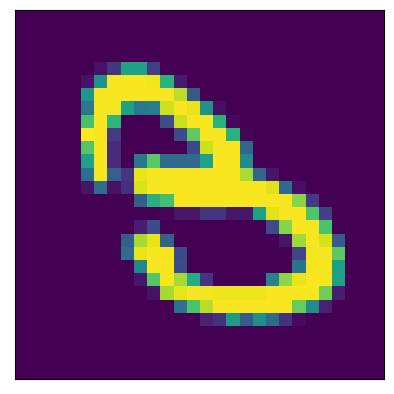

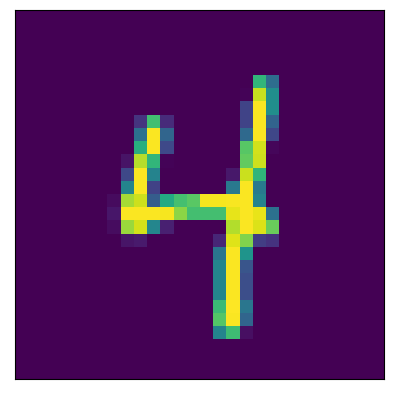

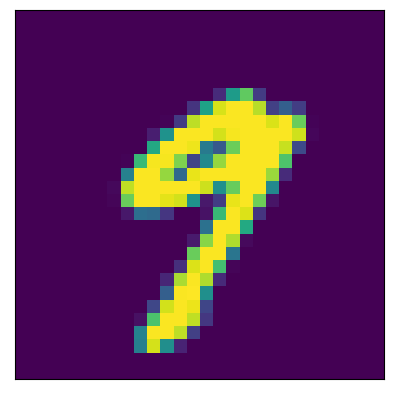

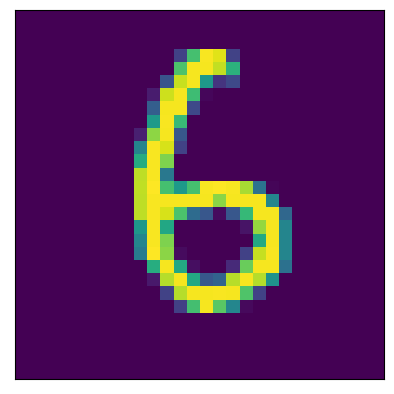

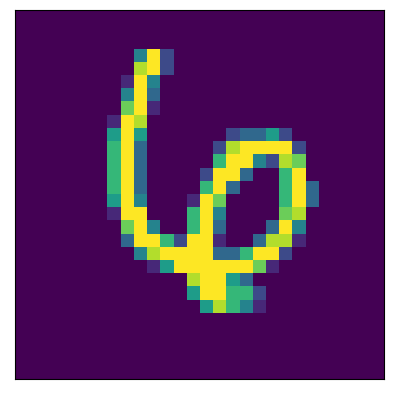

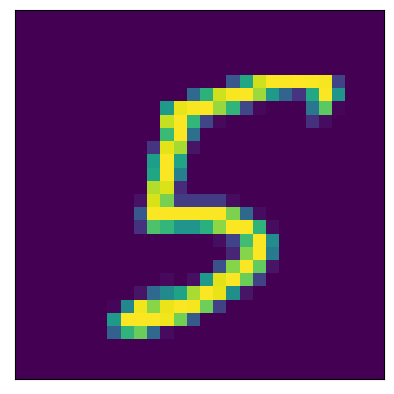

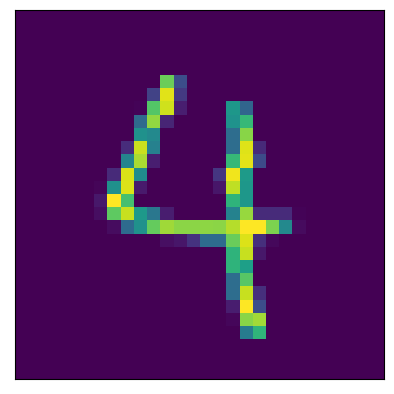

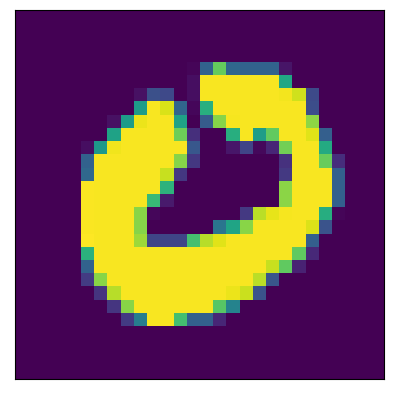

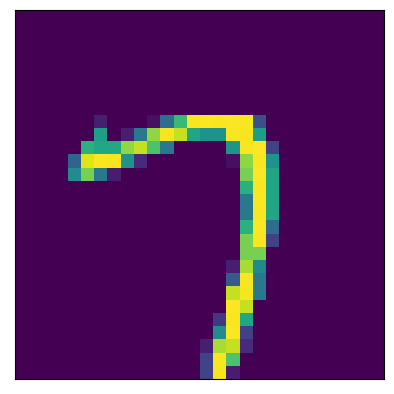

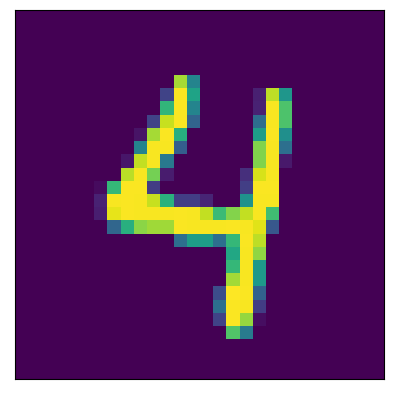

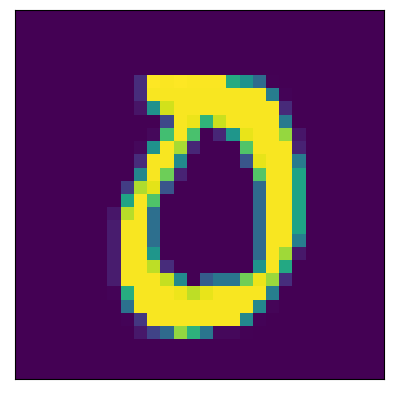

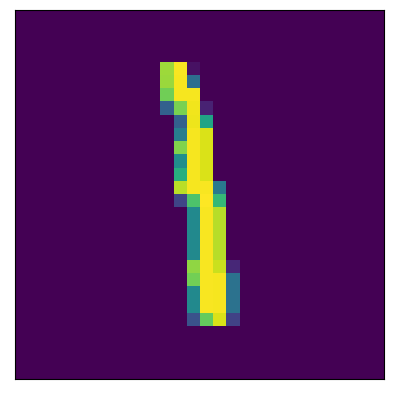

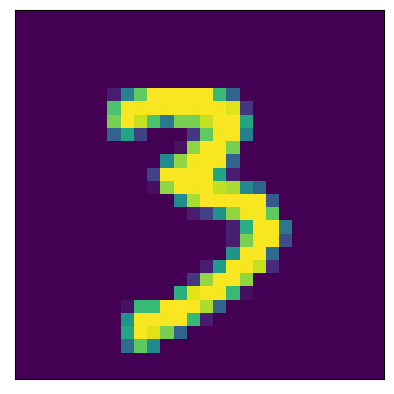

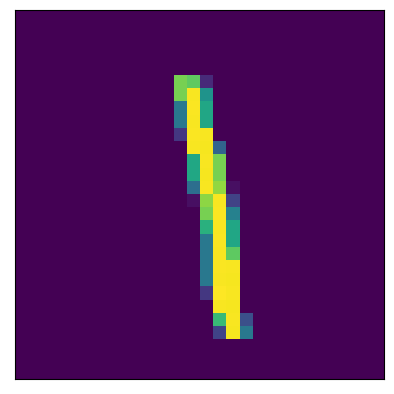

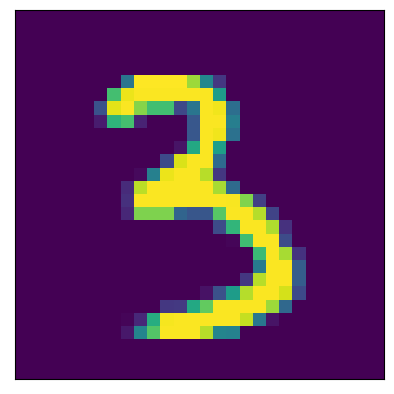

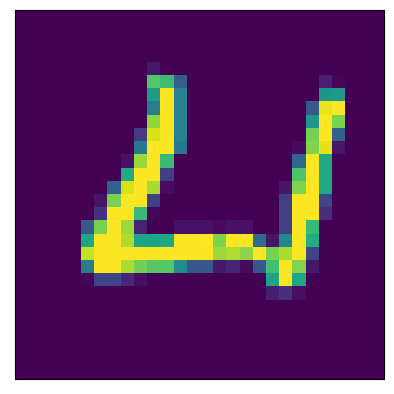

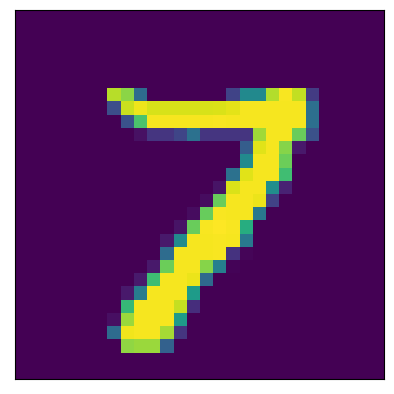

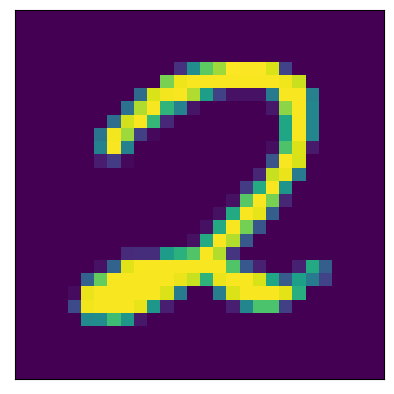

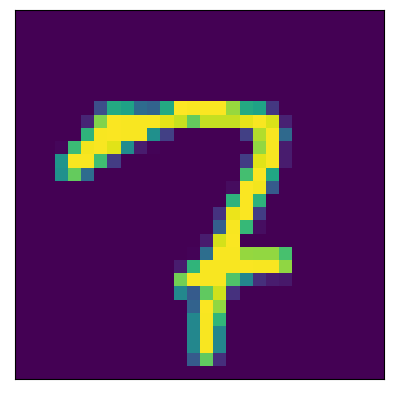

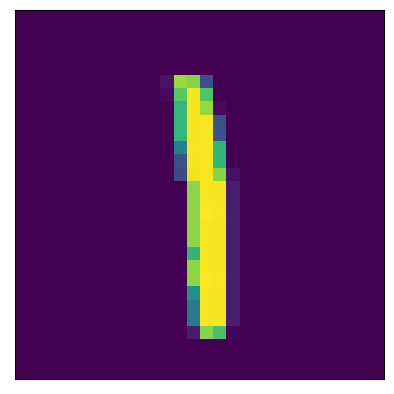

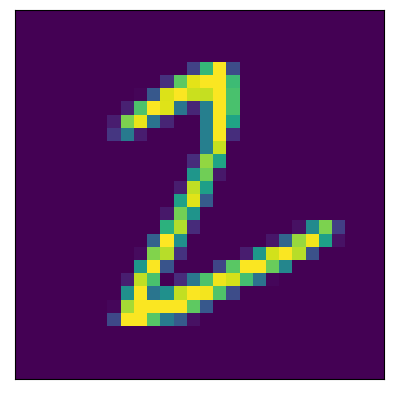

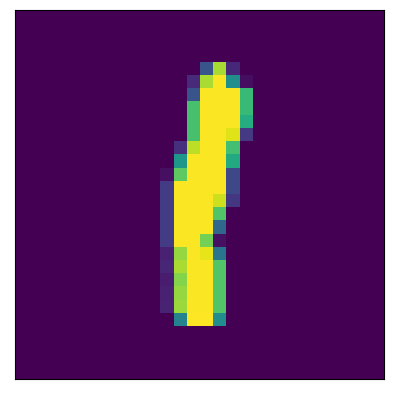

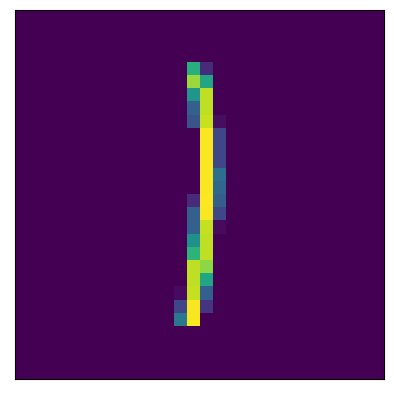

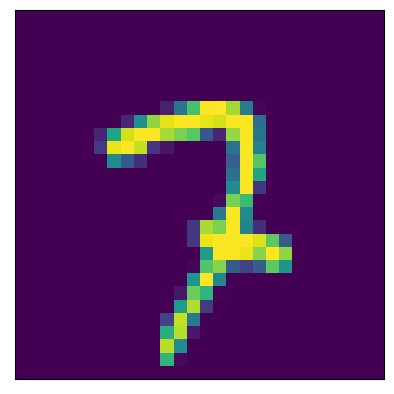

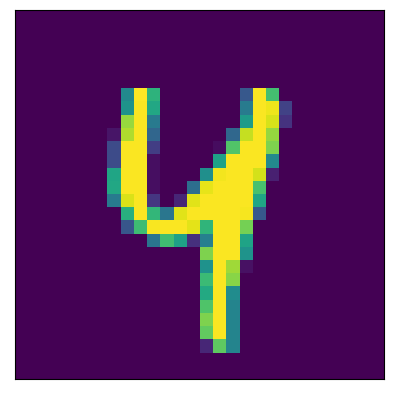

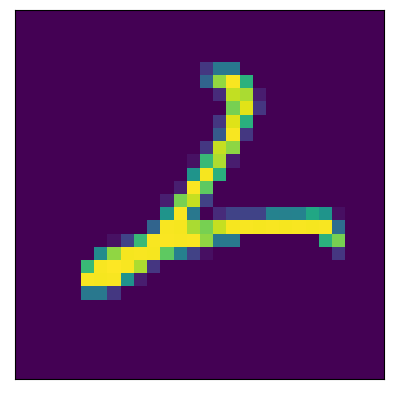

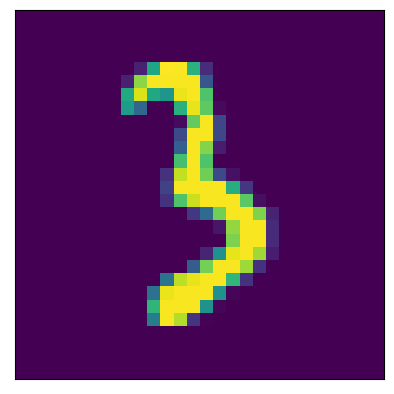

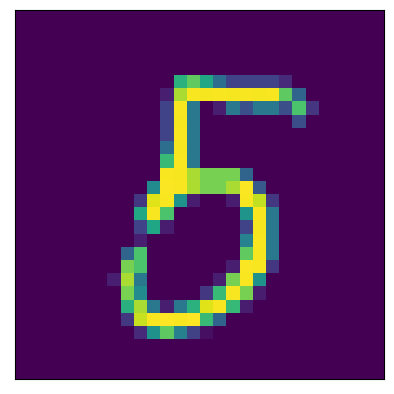

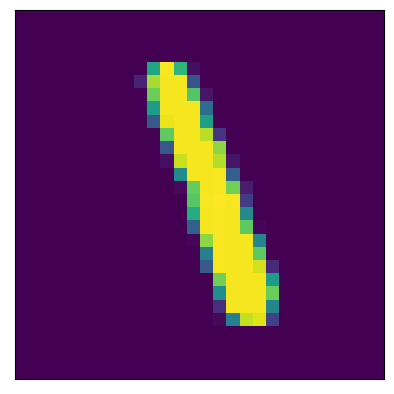

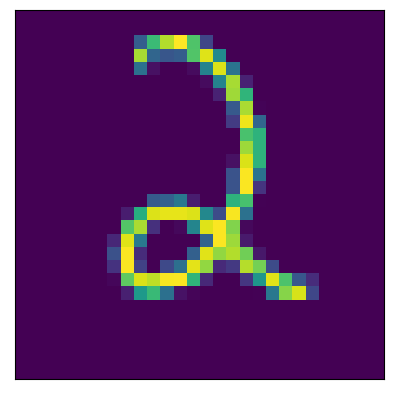

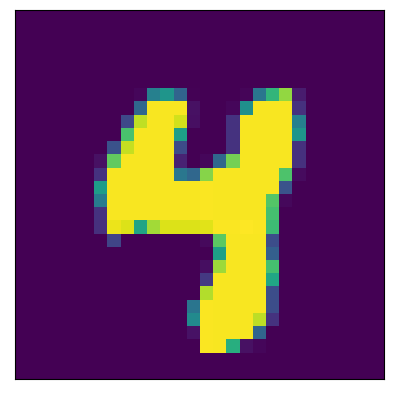

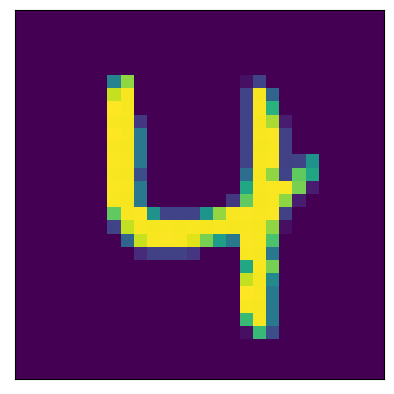

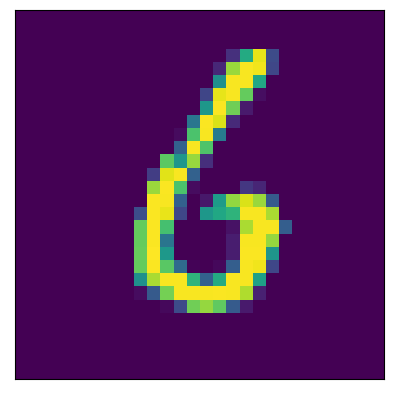

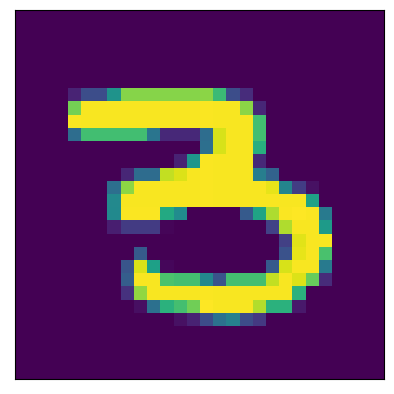

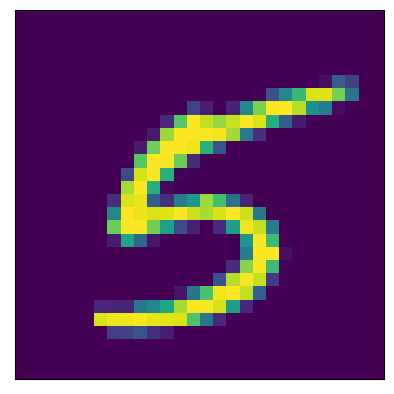

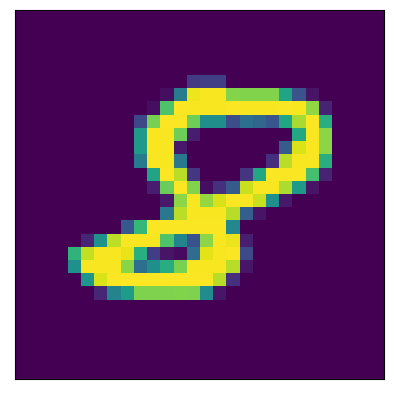

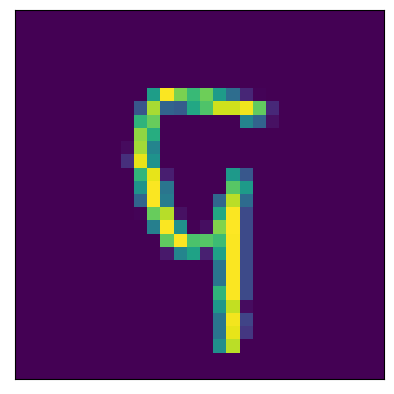

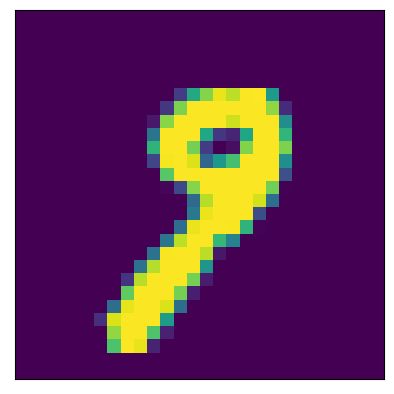

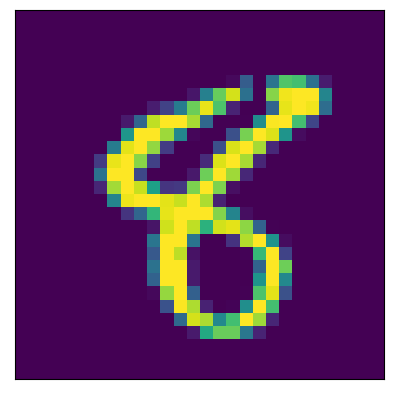

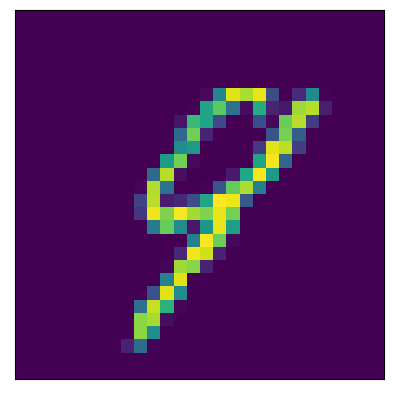

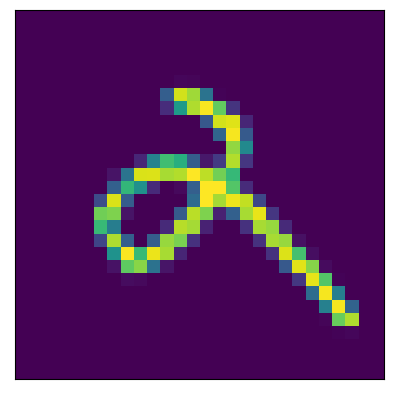

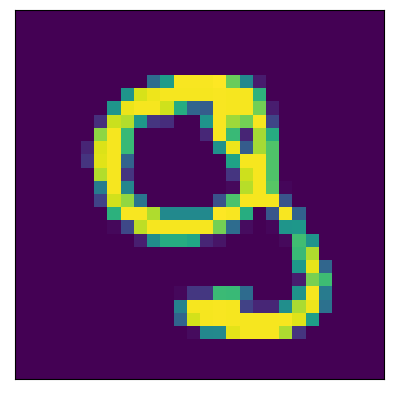

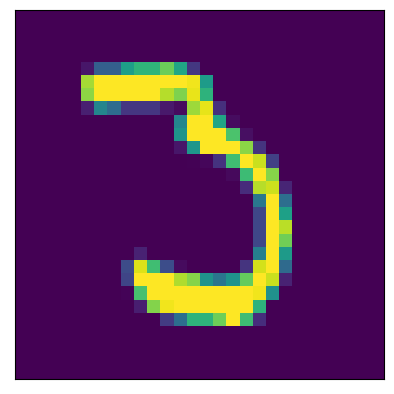

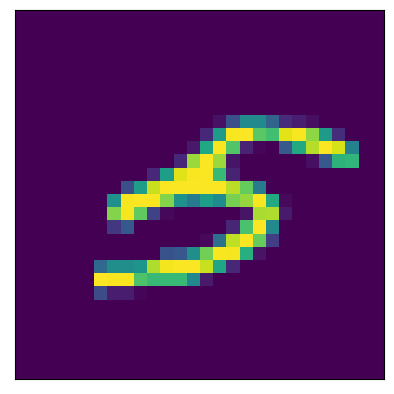

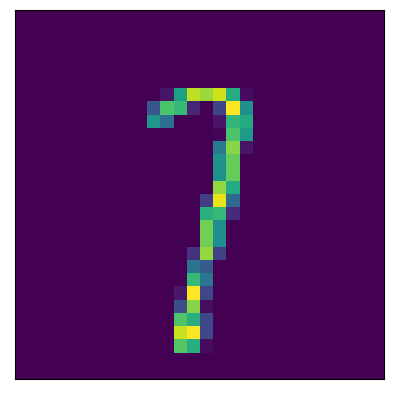

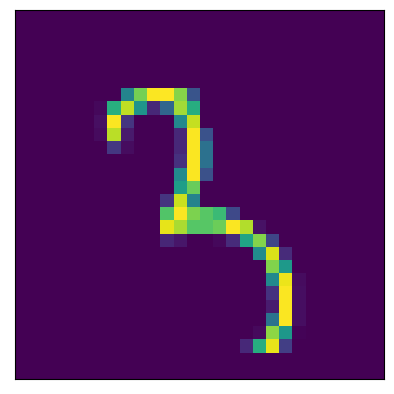

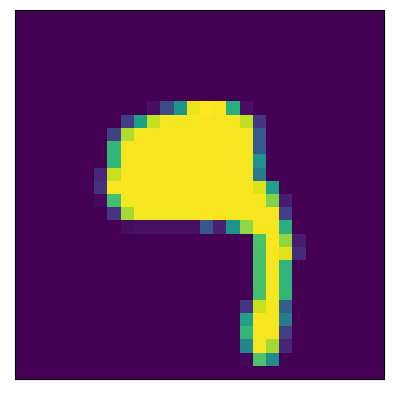

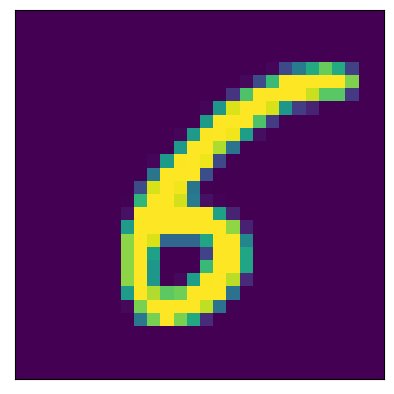

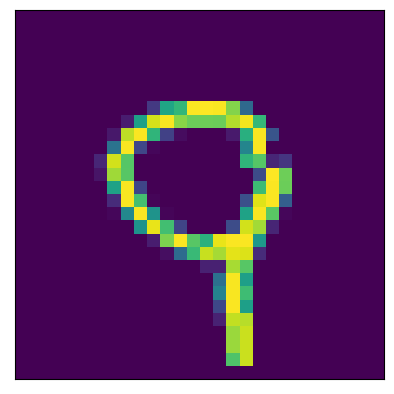

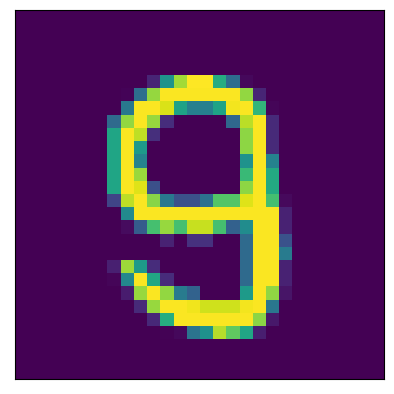

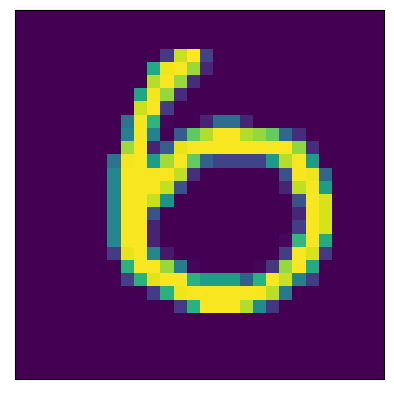

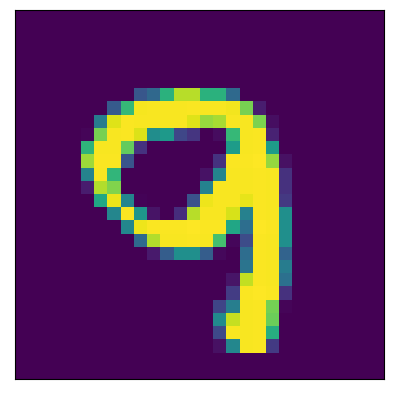

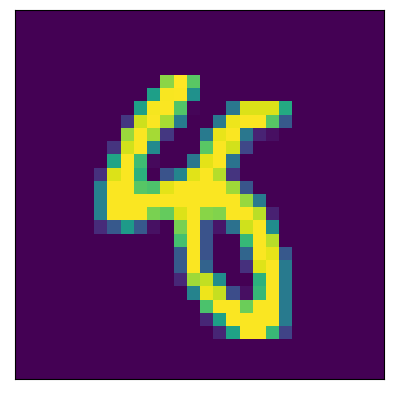

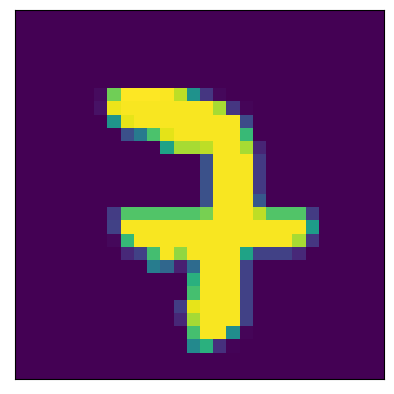

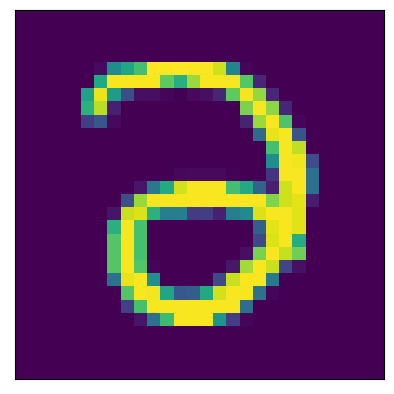

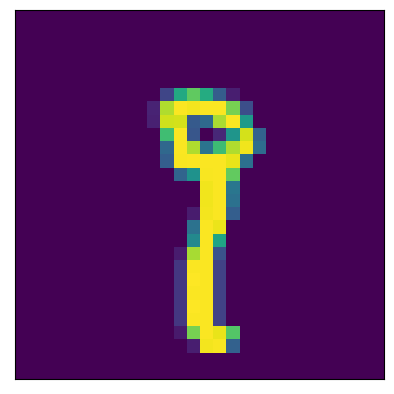

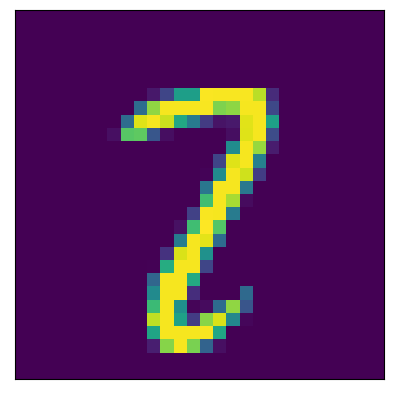

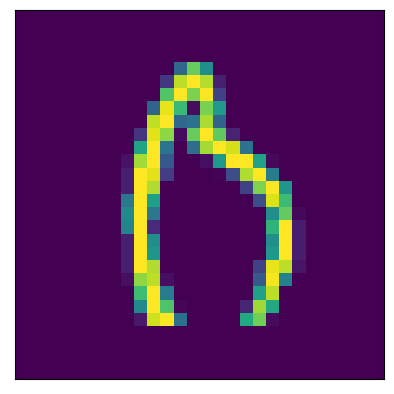

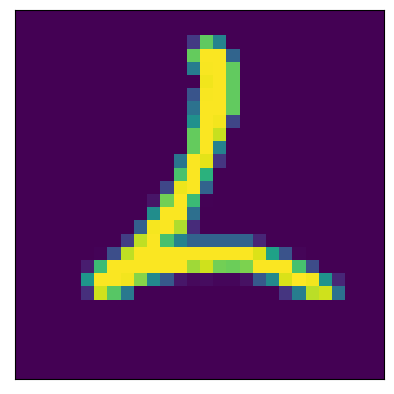

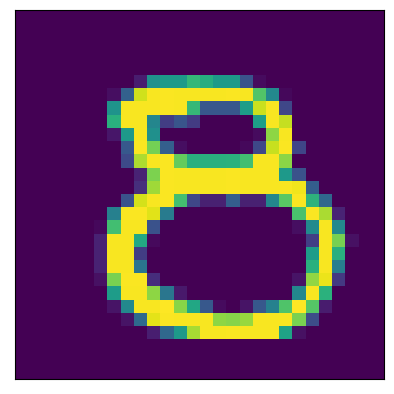

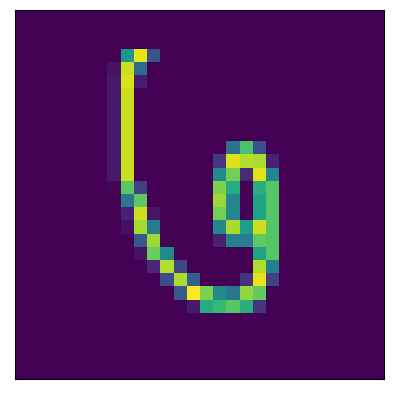

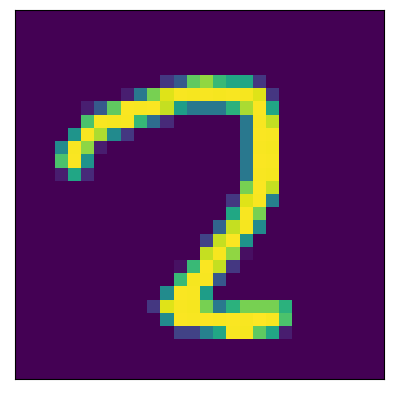

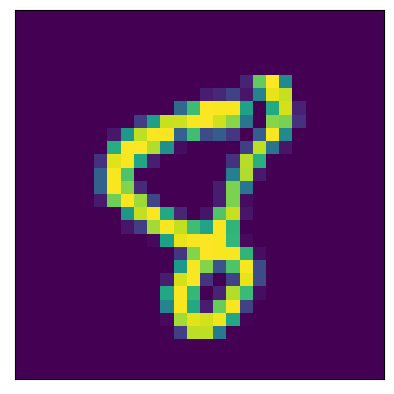

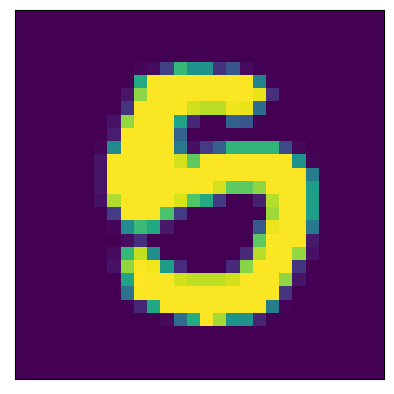

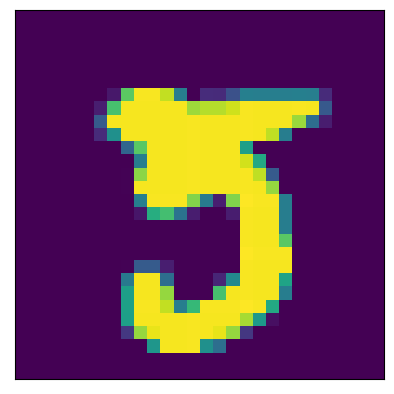

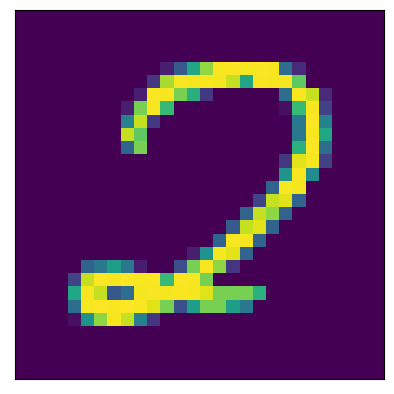

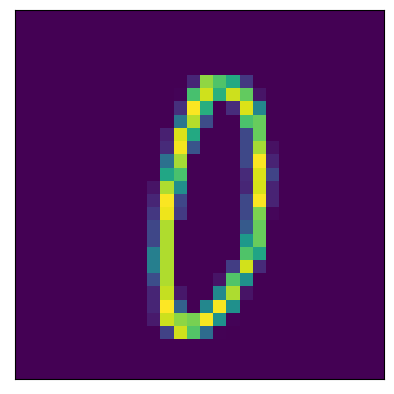

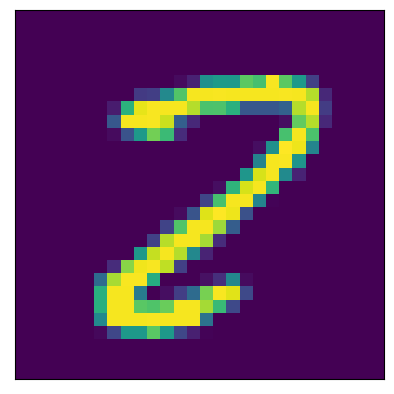

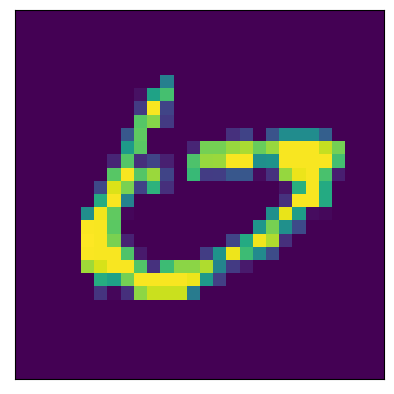

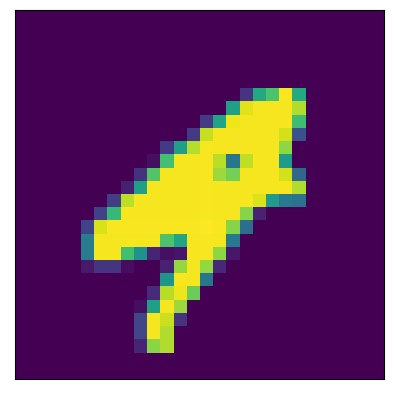

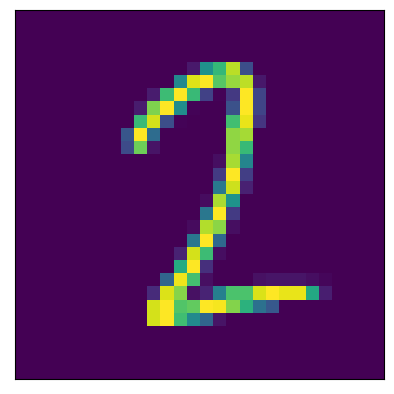

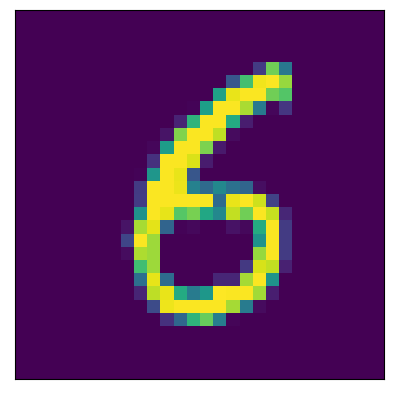

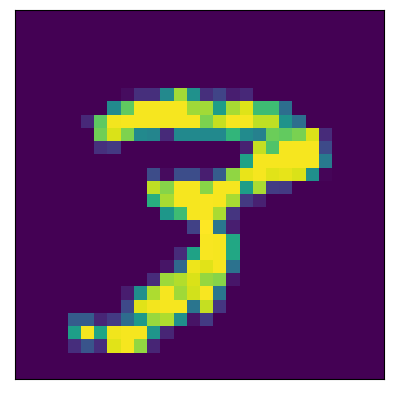

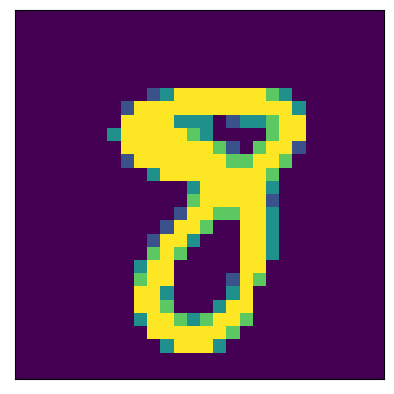

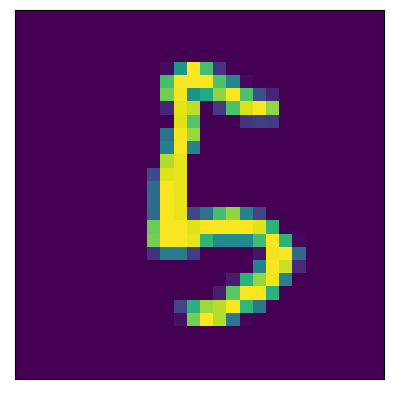

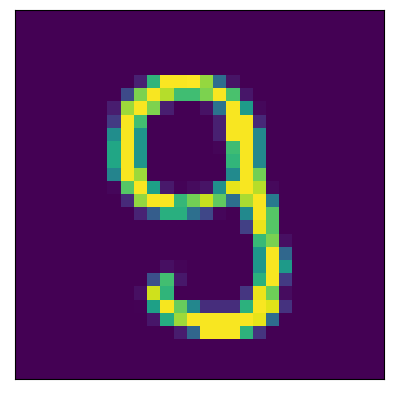

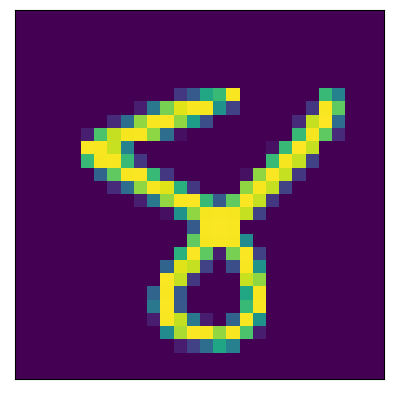

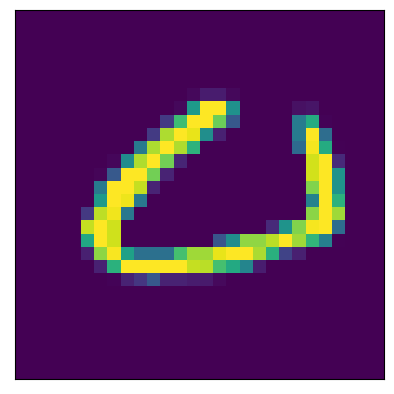

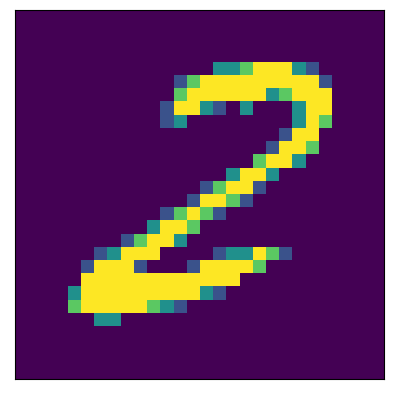

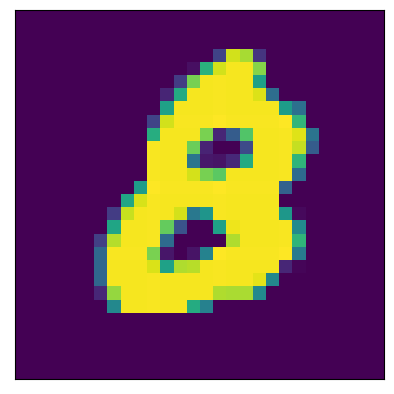

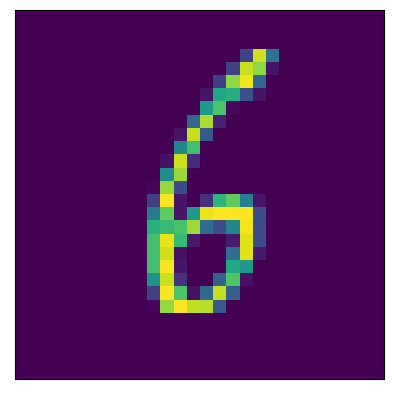

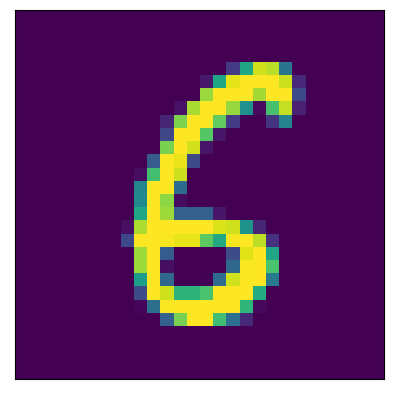

In [27]:
# 找到50个good cases 和 50 个bad cases

plt.close()

for i in tqdm(range(1000)):
    features,label = ds_val[i]
    tensor = features.to(device)
    y_pred = torch.argmax(model(tensor[None,...])) 
    
    # log badcase
    if y_pred!=label:
        if len(bad_cases.data)<50:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            bad_cases.add_data(input_img,label,y_pred)
            
    # log goodcase
    else:
        if len(good_cases.data)<50:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            good_cases.add_data(input_img,label,y_pred)

In [28]:
wandb.log({'good_cases':good_cases,'bad_cases':bad_cases})

In [29]:
wandb.finish() 

best_val_acc,0.91817
epoch,15
val_acc,0.91817
